# Series temporales

# Introducción
Una serie temporal (time series) es una sucesión de datos ordenados cronológicamente, espaciados a intervalos iguales o desiguales. El proceso de Forecasting consiste en predecir el valor futuro de una serie temporal, bien modelando la serie temporal únicamente en función de su comportamiento pasado (autorregresivo) o utilizando otras variables externas a la serie temporal.

A lo largo de este documento, se describe cómo utilizar modelos de regresión de Scikit-learn para realizar forecasting sobre series temporales

In [1]:
pip install session-info

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import statsmodels
import math

from statsmodels.graphics.tsaplots import plot_acf
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import ensemble



# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')

%matplotlib inline

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Librerías adicionales
# ==============================================================================
from sklearn.metrics import r2_score
import statsmodels.api as sm

El dataset (corticoides.csv) que se utilizará en este primer ejercicio se ha obtenido del libro de forecasting de series temporales: [Principles and Practice by Rob J Hyndman and George Athanasopoulos](https://otexts.com/fpp3/).

Se dispone de una serie temporal con el gasto mensual (millones de dólares) en fármacos con corticoides que tuvo el sistema de salud Australiano entre 1991 y 2008. Se pretende crear un modelo autorregresivo capaz de predecir el futuro gasto mensual.

In [3]:
datos = pd.read_csv('corticoides.csv', sep=',')
datos.head()

x       fecha
0  0.429795  1991-07-01
1  0.400906  1991-08-01
2  0.432159  1991-09-01
3  0.492543  1991-10-01
4  0.502369  1991-11-01

La columna fecha se ha almacenado como string. Para convertirla en datetime, se utiliza la función pd.to_datetime(). Una vez en formato datetime, y para utilizar las funcionalidades de pandas, se establece como índice. Además, dado que los datos son mensuales, se indica su frecuencia (Monthly Started 'MS').

In [4]:
# Preparación de datos
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

Verificamos que la serie temporal esté completa.

In [5]:
# Verificar que un índice temporal está completo
# ==============================================================================
(datos.index == pd.date_range(start=datos.index.min(),
                              end=datos.index.max(),
                              freq=datos.index.freq)).all()

True

Utilizaremos los últimos 36 meses como conjunto de test para evaluar la capacidad predictiva del modelo.

In [6]:
TEST_SIZE = 36
train, test = datos.iloc[:-TEST_SIZE], datos.iloc[-TEST_SIZE:]
x_train, x_test = np.array(range(train.shape[0])), np.array(range(train.shape[0], datos.shape[0]))
train.shape, x_train.shape, test.shape, x_test.shape

((168,), (168,), (36,), (36,))

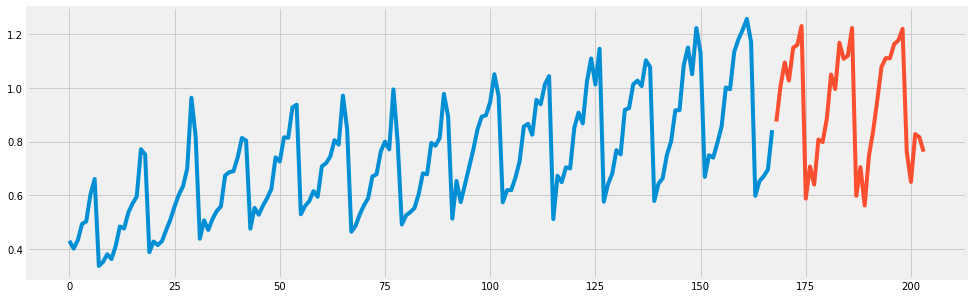

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, train)
ax.plot(x_test, test)

El correcto funcionamiento del modelo de regresión lineal está basado en el cumplimiento de una serie de hipótesis entre las que destacan las relacionadas con el error, que son:

El término error es completamente aleatorio y sigue una distribución normal, de esperanza 0. La varianza del error es constante a lo largo de las observaciones del modelo (Var[εi]=σ2). El término error no está correlacionado entre los elementos del modelo y es independiente de la variable explicativa. La heteroscedasticidad es un problema que surge con el incumplimiento de la segunda hipótesis, lo que implica que la varianza del error debe ser constante a lo largo de las observaciones.

En nuestro caso, observamos que tenemos heterocedasticidad, puesto que la amplitud de onda varía con el tiempo. En este primer apartado debe eliminar la heterocedasticidad de la serie temporal. Es decir, que la diferencia entre lo mínimo y lo máximo de la estacionalidad (anual) sea más o menos a lo largo del tiempo.

<div class="alert alert-block alert-info">
En primer lugar, transformaremos los datos para eliminar la heterocedasticidad. Para ello transformaremos los datos aplicando una serie de funciones
</div> 

Para ver qué función logra que la diferencia entre el mínimo y el máximo de la estacionalidad sea más similar aplicaremos las funciones logarítmica, exponencial y la raíz cuadrada y compararemos los resultados tanto gráfica como numéricamente.

Como haremos el mismo cálculo para los tres casos, creamos una función que calcule la varianza entre los máximos y mínimos de cada año.

In [8]:
def get_mean_var_diferencies(data):
    diferencias = []
    
    # Calculamos la diferencia para cada año
    for a in pd.unique(data.index.year):
        maximo = max(data[data.index.year == a].values)
        minimo = min(data[data.index.year == a].values)
        diferencias.append(np.abs(maximo) - np.abs(minimo))
        
    # Devolvemos la diferencia media y la varianza de las diferencias
    return {"Media:":np.mean(diferencias),"Variancia":np.var(diferencias)}

Obtenemos la varianza de los datos sin transformar para compararlos después:

In [9]:
get_mean_var_diferencies(train)

{'Media:': 0.4973092700000001, 'Variancia': 0.011578623667459854}

**Función exponencial:**

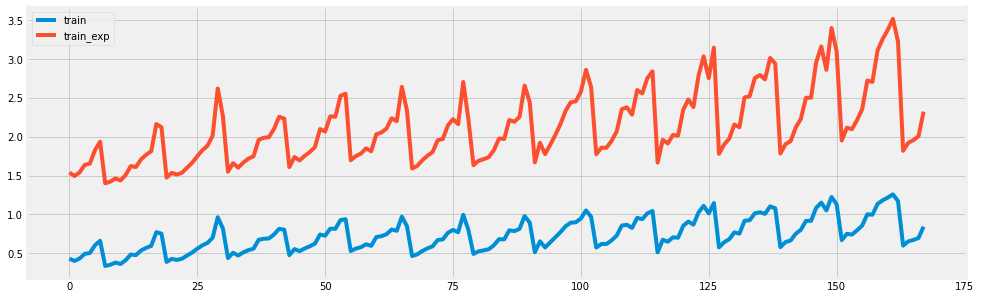

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, train)
ax.plot(x_train, np.exp(train))
plt.legend(["train", "train_exp"])

In [11]:
get_mean_var_diferencies(np.exp(train))

{'Media:': 1.0968666894360561, 'Variancia': 0.11009723100693904}

**Función logaritmica:**

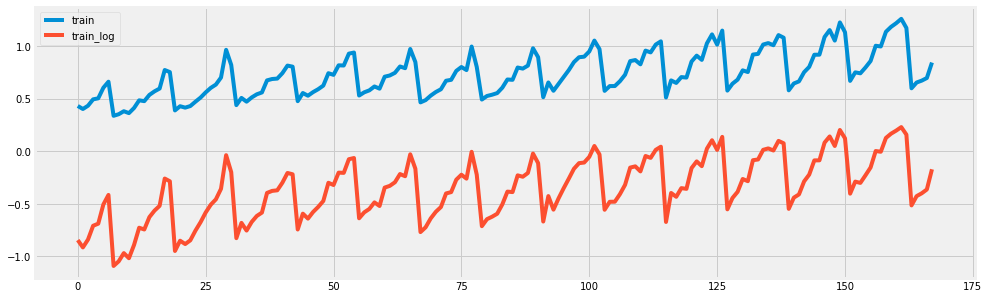

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, train)
ax.plot(x_train, np.log(train))
plt.legend(["train", "train_log"])

In [13]:
get_mean_var_diferencies(np.log(train))

{'Media:': -0.5684882922491845, 'Variancia': 0.0369342444970349}

**Función raíz cuadrada:**

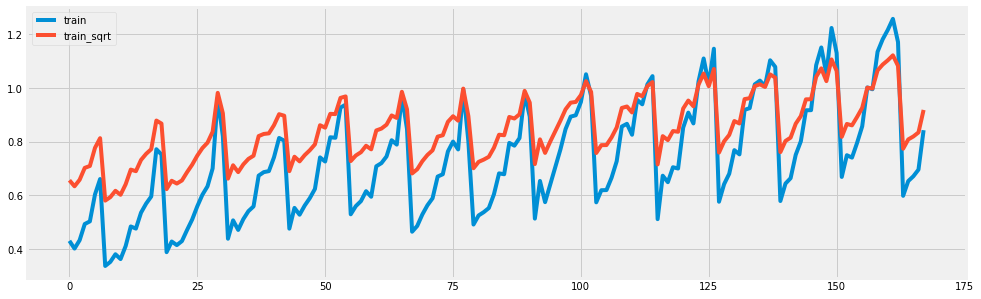

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, train)
ax.plot(x_train, np.sqrt(train))
plt.legend(["train", "train_sqrt"])

In [15]:
get_mean_var_diferencies(np.sqrt(train))

{'Media:': 0.2898207958255757, 'Variancia': 0.002600575253041081}

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> 
</div>

Después de ver los resultados obtenidos, podemos decir que la función que mejor elimina la heteroscedasticidad es la raíz cuadrada.

Gráficamente, podemos comprobarlo al ver que la amplitud de onda varía mucho menos con el tiempo que en los datos originales, aunque puede ser algo más difícil hacer esta comparación entre algunas funciones. Por otra parte, si nos fijan en la varianza obtenida sí que podemos ver claramente cómo con la raíz cuadrada hemos obtenido una varianza mucho menor respecto a su promedio que el resto de funciones.

Por lo que respecta a las funciones exponencial y logarítmica, nos han dado resultados que empeoran los datos originales. Lo podemos ver claramente con la función exponencial, donde en el gráfico se ve que las diferencias son mucho mayores. También podemos comprobarlo con la varianza obtenida.

Vistos estos resultados, nos quedamos con la transformación de los datos realizada por la raíz cuadrada:

In [16]:
train_sqrt = np.sqrt(train)

### Tendencia

<div class="alert alert-block alert-info">
La tendencia es el comportamiento que tiene los datos a largo plazo.

En nuestra serie temporal tenemos una tendencia lineal creciente. En este apartado, eliminaremos la tendencia, quedando una serie temporal con tendencia constante.
</div> 

En primer lugar, ajustamos una regresión lineal a los datos transformados mediante *LinearRegression()*:

In [17]:
trend_model = LinearRegression()

# Ajustamos con los datos de entrenamiento
trend_model.fit(np.arange(train_sqrt.shape[0]).reshape((-1,1)), train_sqrt)

LinearRegression()

Ahora hacemos las predicciones de la regresión para mostrarlas en el gráfico:

In [18]:
predictions = trend_model.predict(np.arange(train_sqrt.shape[0]).reshape((-1,1)))

Visualizamos los datos con la línea de regresión:

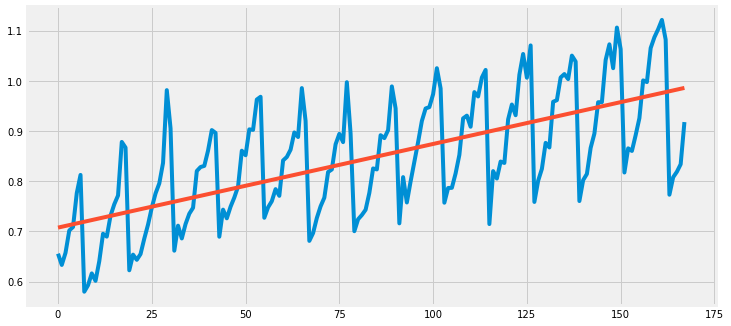

In [19]:
plt.figure(num=1, figsize=(11, 5.5))
plt.plot(x_train, train_sqrt)
plt.plot(predictions)
plt.show()

Ahora que tenemos la tendencia de los datos definida con el modelo de regresión, pasamos a eliminarla de los datos de entrenamiento:

In [20]:
train_sqrt_trend = train_sqrt - predictions

Para comparar el antes y después de eliminar la tendencia, visualizamos los datos originales y los nuevos datos en un mismo gráfico:

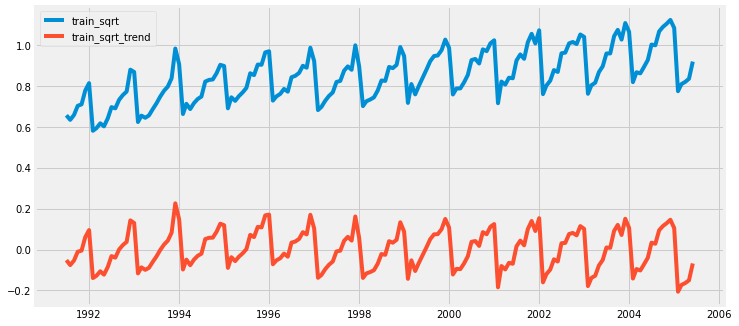

In [21]:
plt.figure(figsize=(11, 5.5))
plt.plot(train_sqrt)
plt.plot(train_sqrt_trend)
plt.legend(["train_sqrt", "train_sqrt_trend"])
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>
</div>

Con la librería *LinearRegressión* hemos obtenido una línea de regresión a partir de los datos de entrenamiento.

Gráficamente hemos visto que el modelo creado se ajusta bastante bien a la tendencia lineal creciente de nuestros datos. Luego hemos eliminado esta tendencia y visualizado ambas series temporales para ver la diferencia. En esa comparación podemos ver los datos con la tendencia eliminada ya no crecen de forma lineal con el tiempo.

Se puede observar cómo se ha reducido la pendiente con la ayuda de la parrilla. En los datos originales, el rango de valores de toda la serie temporal ocupa tres cuadros, en cambio, con la tendencia eliminada, ocupa sólo dos cuadros.

### Estacionalidad

Definimos [estacionalidad](https://analisisdedatos.net/analisis/ST/estacionariedad.php) como la variación cíclica que se produce en los datos. En este apartado encontraremos y eliminaremos la estacionalidad.

#### Encontrar el período de la estacionalidad

Basándonos en lo que hemos visto en las webs de [UH Currents Group](https://currents.soest.hawaii.edu/ocn_data_analysis/_static/SEM_EDOF.html), [kite](https://www.kite.com/python/answers/how-to-calculate-autocorrelation-in-python) y [DelftStack](https://www.delftstack.com/es/howto/numpy/numpy-autocorrelation/), haremos lo siguiente para calcular la autocorrelación mediante NumPy y visualizarla:

1. Seleccionar los 24 primeros valores de la serie temporal
2. Eliminamos la media a estos valores
3. Calculamos la correlación de todos los elementos con el parámetro *mode = full*
4. Normalizamos para tener los valores en el rango [0,1]
5. Seleccionamos sólo los valores de la matriz que queremos, es decir, los 24 elementos que corresponden a la segunda mitad de la matriz que nos devuelve la función *correlate()*.
6. Comprobamos el resultado

In [22]:
n = 24
x = train_sqrt[0:24]

# Indicamos los retrasos
lags = np.arange(0, n)

# Eliminamos la media
x = x - np.mean(x)

# Calculamos los coeficientes de correlación
autocorr = np.correlate(x, x, mode='full')

# Normalizamos
autocorr /= autocorr[n - 1]

# Seleccionamos
autocorr = autocorr[autocorr.size//2:]

# Comprobamos
autocorr

array([ 1.        ,  0.52623798,  0.10814391, -0.06218893, -0.30442707,
       -0.33852278, -0.21791349, -0.23583041, -0.17959372, -0.07765651,
       -0.03502584,  0.18709444,  0.36575999,  0.11938692, -0.02609185,
       -0.11200301, -0.18980863, -0.12931141, -0.01661766,  0.0402182 ,
        0.03664136,  0.02804342,  0.01178431,  0.00168077])

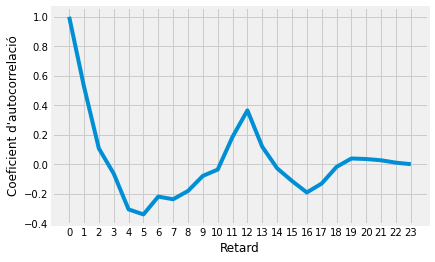

In [23]:
fig, ax = plt.subplots()
ax.plot(lags, autocorr)
ax.set_xlabel("Retard")
ax.set_ylabel("Coeficient d'autocorrelació")

# Mostramos todos los ticks del eje x
# Corresponderán a los retrasos
ax.set_xticks(lags, minor=False)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> 
</div>

El valor máximo que hemos obtenido es 1. Este valor corresponde al retraso 0. Esto es lógico, ya que, como se especifica en el siguiente apartado, en el retraso 0 se está calculando la correlación de un valor consigo mismo y este resultado siempre es 1. Entre un valor y sí mismo la correlación siempre es máxima.

Sin tener en cuenta este retraso, los valores más altos de correlación son los siguientes:
- Retraso 1 = 0.52
- Retraso 5 = -0.33
- Retraso 12 = 0.36

Cabe destacar la correlación de los datos cuando el retraso es 1, es decir, el valor del mes anterior. Este valor de correlación nos indica que el valor actual está positivamente relacionado con el valor del mes anterior, tender a comportarse de la misma manera. También cabe destacar el retraso 12, es decir, un año. Parece que el valor del dato estará relacionado con su valor un año anterior. Todo indica que existe un ciclo anual en la periodicidad de los valores de los datos.

Y en cuanto a la correlación negativa con el retraso 5, podemos ver en los gráficos anteriores que hay un momento en el que el valor del gasto en fármacos con corticoides baja de forma muy notable. Puede que estos fármacos se utilicen para enfermedades estacionarias y con una diferencia de este retraso hay mucho o muy poco uso de los fármacos. Esto explicaría esta correlación negativa, el valor del gasto toma incrementos opuestos cada 5 meses.

#### Aplicar un modelo SARIMA

Para tratar la estacionalidad aplicaremos un modelo SARIMA. Las siglas corresponden a “stationality ARIMA”, es decir, un modelo ARIMA con estacionalidad (la que acabamos de encontrar).

El modelo [ARIMA](https://otexts.com/fpp2/arima.html) nos permitirá tratar el ruido que queda al eliminar la heterocedasticidad, tendencia y estacionalidad. Para ello tiene en cuenta los siguientes componentes:

- AR: auto-regressive, se denomina *p*. Tiene en cuenta la correlación con sus lagos, es decir, mira si las observaciones pasadas afectan para calcular el siguiente punto.
- I: integrated, se llama *d*. Es el orden de diferenciación, en nuestro caso no es necesario, puesto que la serie ya no tiene heterocedasticidad ni tendencia. Por tanto nuestra *d* = 0
- MA: moving-average, se llama *q*. Tiene en cuenta la correlación con los lagos de los errores, es decir, una vez aplicado el modelo, mira los errores del modelo hacia los datos reales.

Los modelos SARIMA dependen de varios parámetros (p,d,q)(P,D,Q)s, donde los primeros (minúsculas) corresponden a AR, I, MA de la serie normal, o los segundos (mayúsculas) a AR, I, MA con estacionalidad.

Para encontrar estos parámetros debemos mirar los gráficos PACF (<i>partial autocorrelation function</i>) y ACF (<i>autocorrelation function</i>).

El gráfico PACF nos determina el parámetro *p*, es decir, el AR.

Describiremos cada una de las partes:

#### ¿Qué entendemos por autocorrelación en las series temporales?
Es un término estadístico que se utiliza para describir la presencia o ausencia de correlación en los datos de las series temporales, indicando si las observaciones pasadas influyen en las actuales.

Por tanto, podemos decir que la autocorrelación hace referencia cuando los valores que toman una variable en el tiempo no son independientes entre sí, sino que un valor determinado depende de los valores anteriores.

El problema de la autocorrelación se llama a menudo de **“correlación serial”**.

Para medir la autocorrelación se suele utilizar:

La **función de autocorrelación (ACF)**:
- Mide la correlación entre dos variables separadas por k períodos.
- Mide el grado de asociación lineal existente entre dos variables del mismo proceso estocástico.

La **función de autocorrelación parcial (PACF)**
- Mide la correlación entre dos variables separadas por k períodos cuando no se considera la dependencia creada por los retrasos intermedios existentes entre ambas.
- Mide la autocorrelación que existe entre dos variables separadas k períodos descontando los posibles efectos debidos a variables intermedias.

Por tanto, la función ACF es usada para identificar el proceso de media móvil (MA) en un modelo ARIMA; mientras que la función PACF se utiliza para identificar los valores de la parte del proceso autorregresivo (AR).

Los gráficos generados a partir de estas funciones se denominan **correlogramas**, que contienen bandas con un intervalo de confianza del 95%.

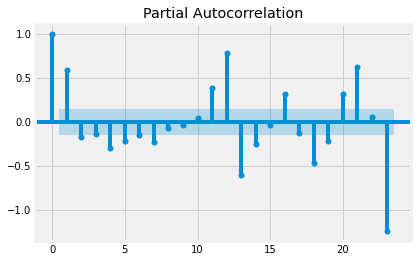

In [24]:
plot_pacf(train_sqrt_trend)
plt.show()

Para leer este gráfico, simplemente debemos fijarnos en los valores que salen fuera del intervalo de confianza (zona azul).

Nada más empezar hay dos valores fuera del intervalo. De todas formas, el primero no debe tenerse en cuenta, ya que mira la correlación de un valor consigo mismo (lag0), y ésta siempre será 1. Si no tenemos en cuenta este primer valor, sólo hay un valor fuera del intervalo de confianza antes de que éste cambie de signo, por lo que p = 1.

Cuando se repite el ciclo, es decir, a partir del valor 12 (recordemos que éste es el lag11, vuelve a haber un valor fuera del intervalo antes de que éste cambie de signo, con lo que P = 2).

Veamos ahora el gráfico ACF, éste determinará el valor de q.

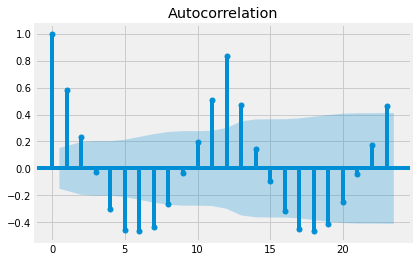

In [25]:
plot_acf(train_sqrt_trend)
plt.show()

Este gráfico se lee como el anterior. Nada más empezar hay dos valores fuera del intervalo (recordemos que el lag0 no lo contamos), con lo que q = 2. Cuando se repite el ciclo, es decir, a partir del valor 11, hay dos valores fuera del intervalo, con lo cual Q = 2.

Dado que los datos no tienen ni tendencia ni heterocedasticidad (se la hemos quitado en apartados anteriores), d = D = 0.

Como hemos visto en el apartado anterior, el ciclo es 12, por lo que s = 12.

**NOTA:** Este apartado está extraído de la teoría y los ejercicios realizados en la UOC (Universitat Oberta de Catalunya)

## Predicciones

A partir de los valores de los parámetros definidos en el apartado anterior aplicamos un modelo SARIMA mediante la función *SARIMAX()*:

In [26]:
# Construimos el modelo
sarimax_model = sm.tsa.statespace.SARIMAX(train_sqrt_trend, trend='c', order=(1,0,2), seasonal_order=(2,0,2,12))

# Ajustamos los datos de entrenamiento
results = sarimax_model.fit()

Visualizamos los datos reales frente a los datos ajustados por el modelo:

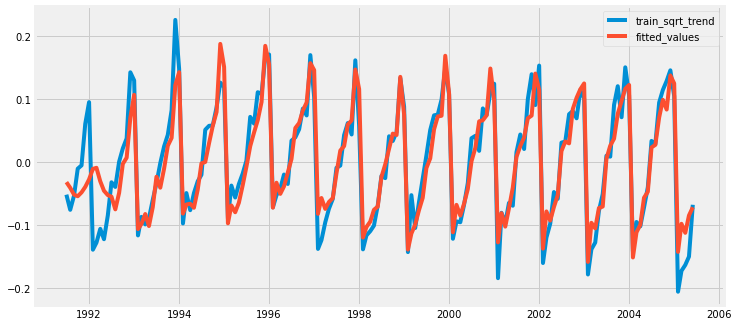

In [27]:
plt.figure(figsize=(11, 5.5))
plt.plot(train_sqrt_trend)
plt.plot(results.fittedvalues)
plt.legend(["train_sqrt_trend", "fitted_values"])
plt.show()

<div class="alert alert-block alert-info">
    <strong>Análisis:</strong>
</div> 

Hemos creado el modelo con los valores de (p,d,q)(P,D,Q)s que hemos visto anteriormente: (1,0,2)(2,0,2)12

En el gráfico con los datos reales y los ajustados del modelo podemos ver cómo por lo general se ajusta bastante bien. Donde más diferencias existen es en los primeros años donde sí vemos claras diferencias entre los valores del modelo y los valores reales. Puede ser lógico, ya que para estos datos iniciales no existen datos anteriores, lo que sí tenemos para el resto de datos.

### Predicción SARIMA

Utilizaremos el modelo SARIMA que hemos filtrado antes para predecir los tres próximos años (que son los años que hemos sacado anteriormente).

<div class="alert alert-block alert-info">
Generaremos tres años de datos predichos mediante el modelo SARIMA realizado en el apartado anterior.
</div>

En primer lugar, vemos el rango de fechas que tenemos en los datos de test:

In [28]:
print(min(test.index))
print(max(test.index))

2005-07-01 00:00:00
2008-06-01 00:00:00


Predimos este rango de años indicando estos valores en los parámetros *start* y *end* de la función *predict()* del modelo ajustado:

In [29]:
predict_3years = results.predict(start=pd.to_datetime('2005-07-01'),end=pd.to_datetime('2008-06-01'))

Visualizamos los datos de entrenamiento y los datos de nuestra predicción:

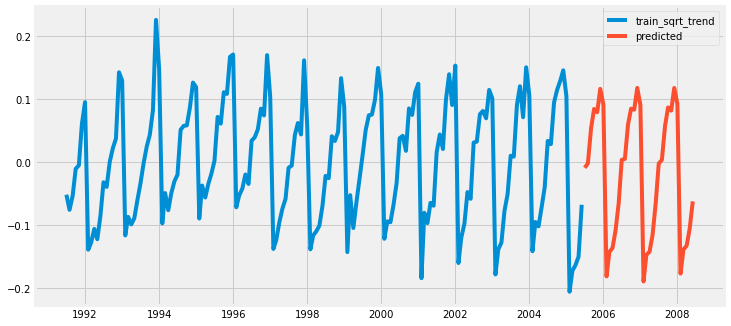

In [30]:
plt.figure(figsize=(11, 5.5))
plt.plot(train_sqrt_trend)
plt.plot(predict_3years)
plt.legend(["train_sqrt_trend", "predicted"])
plt.show()

En el gráfico podemos ver cómo los valores predichos para los próximos años parece que siguen el mismo ciclo realizado hasta ahora. Sí podemos darnos cuenta de que varían menos entre ellos que el resto de años. Esto no tiene por qué ser negativo o positivo, más adelante calcularemos el error para saber lo bien que se ha ajustado el modelo al realizar la predicción para estos tres próximos años.

### Tendencia

<div class="alert alert-block alert-info">
Anteriormente hemos visto que los datos de la serie temporal tienen una tendencia lineal y la hemos calculado mediante una regresión lineal. Añadimos esta tendencia a nuestra predicción.
</div> 

Realizamos el proceso inverso al realizado en el apartado 1.1.b:

In [31]:
train_sqrt = train_sqrt_trend + predictions

Ahora ya tenemos la tendencia añadida a los datos de entrenamiento, pero no a los datos predichos. Para añadir la tendencia a estos datos, deberemos calcular la tendencia de los datos de test, ya que en el apartado 1.1.b sólo habíamos calculado la de los datos de entrenamiento y no sobre estos 3 años.

Como tenemos el modelo ya calculado, éste será un paso sencillo. Para predecir los nuevos datos y obtener su tendencia para poder añadirla, sumamos 36 al rango, puesto que queremos tener los 3 años. Predeciremos los valores para los elementos en el rango [168,203]

In [32]:
predictions = trend_model.predict(np.arange(train_sqrt.shape[0],train_sqrt.shape[0]+36).reshape((-1,1)))

Añadimos la tendencia a los datos obtenidos mediante el modelo *SARIMA*:

In [33]:
predict_3years = predict_3years + predictions

Visualizamos los datos de entrenamiento y predichos con la tendencia ya añadida:

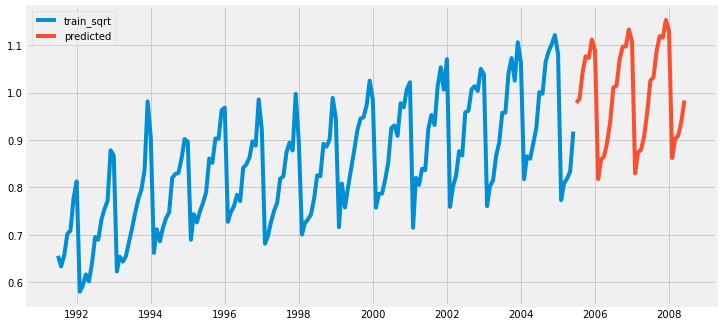

In [34]:
plt.figure(figsize=(11, 5.5))
plt.plot(train_sqrt)
plt.plot(predict_3years)
plt.legend(["train_sqrt", "predicted"])
plt.show()

Comprobamos cómo volvemos a tener una tendencia lineal creciente. Los datos de los próximos tres años predichos con el modelo calculado se ajustan perfectamente a la tendencia general de la serie temporal.

### Heterocedasticidad

<div class="alert alert-block alert-info">
En el primer apartado de esta práctica hemos visto que la serie temporal tiene heterocedasticidad y la hemos eliminado transformando los datos. En este apartado realizaremos la transfromación inversa para añadir heterocedasticidad a nuestra predicción.
</div> 

Invertimos la transformación realizada elevando al cuadrado tanto los datos de entrenamiento como de los datos predichos del modelo:

In [35]:
train = train_sqrt**2
predict_3years = predict_3years**2

Visualizamos:

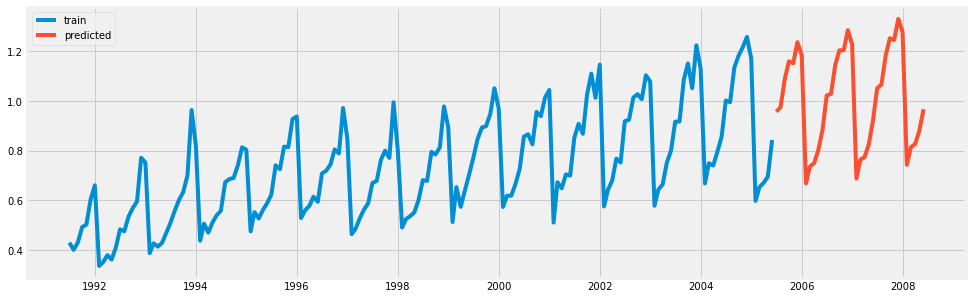

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plt.plot(train)
plt.plot(predict_3years)
plt.legend(["train", "predicted"])
plt.show()

Ahora volvemos a tener los datos en la escala original. Podemos ver cómo existe más variación en los valores máximos y mínimos de los datos.

<div class="alert alert-block alert-info">
Ahora añadimos al gráfico anterior los datos de test para ver si coinciden con la predicción.
</div> 

En el gráfico anterior añadimos los datos de test para comprobar lo bien que se ajustan los datos predichos a los datos reales:

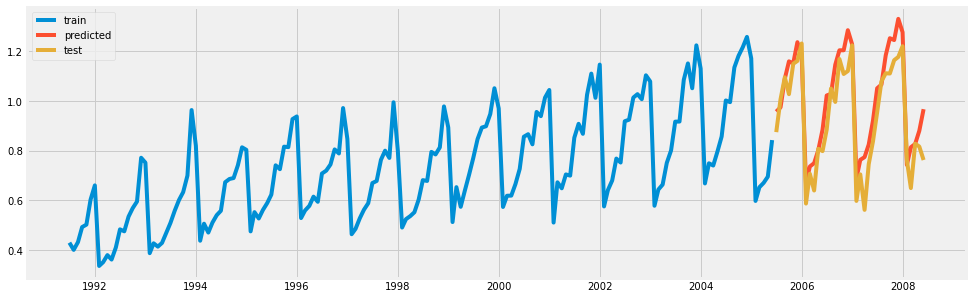

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plt.plot(train)
plt.plot(predict_3years)
plt.plot(test)
plt.legend(["train", "predicted", "test"])
plt.show()

Los valores predichos se ajustan bastante bien, son bastante similares a los reales. Donde parece haber mayor error es en los valores máximos y mínimos que podemos tener durante los distintos años.

<div class="alert alert-block alert-info">
Una vez realizada la predicción, calculamos el error cometido.
</div> 

Antes de calcular el error, vemos lo bien que se ajusta a los datos con la métrica *r_squared*:

In [38]:
R2 = r2_score(test, predict_3years)
R2

0.7722132739978094

El modelo creado es capaz de contar casi el 78% de los datos de los tres años escogidos.

Calculamos ahora el error mediante MSE:

In [39]:
MSE = mean_squared_error(test, predict_3years)
MSE

0.009720806224401208

Y si queremos tener el valor del error en el mismo formato que los datos, podemos calcular RMSE:

In [40]:
RMSE = np.sqrt(MSE)
RMSE

0.09859414903736026

Teniendo en cuenta que el rango de valores de los datos está entre [0.3 y 1.3], podemos decir que es un error bastante pequeño, tal y como ya prevemos con el gráfico.

Sin embargo, aunque sea un error pequeño, hay que tener en cuenta que la unidad de los datos son millones de dólares. Este error puede suponer un perjuicio bastante elevado como podría ser destinar una partida insuficiente de recursos para fármacos y tener pocas unidades durante los momentos que más falta hagan.

Dependiendo de los requisitos en cuanto al mayor error que se está dispuesto a cometer, este modelo podría ser adecuado o no para calcular el gasto de fármacos en los próximos años.

# Conclusiones

En este documento, hemos tratado una serie temporal. Hemos analizado los componentes que la forman y tratado para poder aplicar un modelo SARIMA con el que hemos predicho los valores de los próximos tres años. Luego hemos comparado estos valores con los valores reales de los datos de test que habíamos reservado y así saber tanto gráfica como numéricamente el error que comete el modelo cuando intenta predecir valores futuros.